In [1]:
import cv2                 
import numpy as np         
import os                 
from random import shuffle
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math

In [2]:
# Guadamos la dirección de los set
DATA_DIR =r'''C:\Users\PABLO\Documents\MEGA\MASTER\TFM\CNN\dataset'''

In [3]:
# Definimos el tamaño de nuestras imagenes.
img_size = 48
# Guardamos las imagenes in un array unidimensional.
img_size_flat = img_size * img_size
# le damos a nuestras imagenes la forma que hemos definido anteriormente.
img_shape = (img_size, img_size)
# Número de canales de nuestras imagenes, en nuestro caso 1, ya que son en 
# escala de grises
num_channels = 1
# Definimos las clases que vamos a tener
num_classes = 2

In [4]:
# Tensorflow utiliza one-hot arrays para guardar las etiquetas, por los tanto,
# definiremos esta función para que cambie las etiquetas de nuestros sets.
def label_img(img):
    word_label = img.split('.')[-3]
    # [1,0] para gatos
    if word_label == 'cat': return [1,0]
    # [0,1] para perros
    elif word_label == 'dog': return [0,1]

In [7]:
# Guaradamos nuestras imagenes en un array para posteriormente procesarlas
def create_dataset():
    dataset = []
    for img in (os.listdir(DATA_DIR)):
        label = label_img(img)
        path = os.path.join(DATA_DIR,img)
        img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (img_size,img_size))
        dataset.append([np.array(img),np.array(label)])
    # Mezaclamos las imagenes    
    shuffle(dataset)
    return dataset

In [8]:
data = create_dataset()
data = np.array(data)

In [9]:
# La longitud de nuestro array será por tanto de 20000 imagenes
len(data)

20000

In [11]:
# La forma de nuestro array será la siguiente, el array de la imágen y el one-hot 
# array para las etiquetas
data[0]

array([ array([[  7,   8,   9, ...,  11,  79, 169],
       [  7,   6,   8, ...,  97,  59, 167],
       [  6,   6,   7, ...,  96,  72, 173],
       ..., 
       [ 18,  15,  30, ...,  20,  39,  38],
       [ 19,  15,  35, ...,  21,  41,  36],
       [ 21,  14,  37, ...,  22,  47,  32]], dtype=uint8),
       array([1, 0])], dtype=object)

In [12]:
# Por ejemplo la primera imagen tendrá la siguiente forma
data

array([[ array([[  7,   8,   9, ...,  11,  79, 169],
       [  7,   6,   8, ...,  97,  59, 167],
       [  6,   6,   7, ...,  96,  72, 173],
       ..., 
       [ 18,  15,  30, ...,  20,  39,  38],
       [ 19,  15,  35, ...,  21,  41,  36],
       [ 21,  14,  37, ...,  22,  47,  32]], dtype=uint8),
        array([1, 0])],
       [ array([[ 18,  18,  20, ...,  24,  23,  22],
       [ 22,  23,  22, ...,  24,  26,  27],
       [ 21,  22,  23, ...,  26,  29,  30],
       ..., 
       [201, 217, 197, ..., 169, 152, 161],
       [202, 192, 201, ..., 157, 154, 142],
       [144, 164, 176, ..., 136, 132, 148]], dtype=uint8),
        array([1, 0])],
       [ array([[227, 230, 230, ...,  59,  58,  12],
       [226, 229, 231, ...,  32,  20,  26],
       [205, 202, 206, ...,  18,  28,  25],
       ..., 
       [114, 111, 108, ...,  81,  88, 110],
       [105, 104,  99, ..., 134, 142, 135],
       [105,  99,  88, ..., 101,  97, 103]], dtype=uint8),
        array([1, 0])],
       ..., 
       [ arr

In [13]:
# Ahora separamos nuestras imagenes en dos grupos, imagenes para el training (15000)
# e imagenes para el test (5000)
train = data[:-5000]
test = data[-5000:]

In [14]:
len(train)

15000

In [15]:
len(test)

5000

In [16]:
# Para ver nuestro set de una forma más visual creamos una función que nos permita
# ver este set
def plot_images(images, cls_true, misclasified_images=False):
    # Mostraremos 9 imagenes con su etiqueta
    assert len(images) == len(cls_true) == 9
    # Creamos una figura de 3x3 imagenes
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Suavizamos la imagen con un filtro spline
        interpolation = 'spline16'
        ax.imshow(images[i].reshape(img_shape), interpolation=interpolation, cmap='gray')
        
        if np.argmax(cls_true[i]) == 1: str_label='Dog'
        else: str_label='Cat'
            
        # Mostramos las imagenes que no ha clasificado bien
        if misclasified_images:
            if np.argmax(cls_true[i]) == 1: pred_label='Cat'
            else: pred_label='Dog'
            xlabel = "True: {0}, Pred: {1}".format(str_label, pred_label)
            
        else:
            xlabel = "True: {0}".format(str_label)

        # Mostramos las etiquetas debajo de cada imagen
        ax.set_xlabel(xlabel)
        
        # Eliminamos los bordes de las imagenes
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.show()

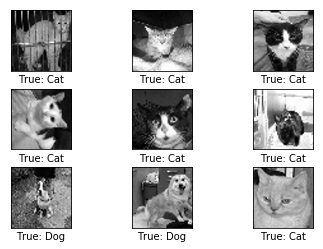

In [17]:
# Antes de mostar nuestro set debemos dividir cada uno de los set en imagenes y etiquetas
training_images=train[:,0]
training_labels=train[:,1]
testing_images=test[:,0]
testing_labels=test[:,1]
images=training_images[0:9]
cls_true=training_labels[0:9]

plot_images(images=images, cls_true=cls_true)

In [18]:
# Creamos un array plano con 0 para gatos y 1 para perros
data_test_cls=np.zeros(shape=len(testing_labels), dtype=np.int64)
for i in range(0,len(data_test_cls)):
    if np.argmax(testing_labels[i]) == 1: str_label=1 # DOG
    else: str_label=0 # CAT
    data_test_cls[i]=str_label

In [19]:
len(data_test_cls)

5000

In [23]:
data_test_cls

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [25]:
# Definimos las funciones para crear y actualizar los pesos y los biases 
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))

def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

In [26]:
# Creamos una funcion para crear capas convolucionales
def new_conv_layer(input,              # Capa anterior, o grupo de imagenes
                   num_input_channels, # Neuronas de la capa anterior
                   filter_size,        # Tamaño del filtro
                   num_filters,        # Número de filtros
                   use_pooling=True):  # Si es True utiliza 2x2 max-pooling.

    # Shape of the filter-weights for the convolution.
    # This format is determined by the TensorFlow API.
    shape = [filter_size, filter_size, num_input_channels, num_filters]

    # Create new weights aka. filters with the given shape.
    weights = new_weights(shape=shape)

    # Create new biases, one for each filter.
    biases = new_biases(length=num_filters)

    # Create the TensorFlow operation for convolution.
    # Note the strides are set to 1 in all dimensions.
    # The first and last stride must always be 1,
    # because the first is for the image-number and
    # the last is for the input-channel.
    # But e.g. strides=[1, 2, 2, 1] would mean that the filter
    # is moved 2 pixels across the x- and y-axis of the image.
    # The padding is set to 'SAME' which means the input image
    # is padded with zeroes so the size of the output is the same.
    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME')

    # Add the biases to the results of the convolution.
    # A bias-value is added to each filter-channel.
    layer += biases

    # Use pooling to down-sample the image resolution?
    if use_pooling:
        # This is 2x2 max-pooling, which means that we
        # consider 2x2 windows and select the largest value
        # in each window. Then we move 2 pixels to the next window.
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')

    # Rectified Linear Unit (ReLU).
    # It calculates max(x, 0) for each input pixel x.
    # This adds some non-linearity to the formula and allows us
    # to learn more complicated functions.
    layer = tf.nn.relu(layer)

    # Note that ReLU is normally executed before the pooling,
    # but since relu(max_pool(x)) == max_pool(relu(x)) we can
    # save 75% of the relu-operations by max-pooling first.

    # We return both the resulting layer and the filter-weights
    # because we will plot the weights later.
    return layer, weights

In [27]:
def flatten_layer(layer):
    # Get the shape of the input layer.
    layer_shape = layer.get_shape()

    # The shape of the input layer is assumed to be:
    # layer_shape == [num_images, img_height, img_width, num_channels]

    # The number of features is: img_height * img_width * num_channels
    # We can use a function from TensorFlow to calculate this.
    num_features = layer_shape[1:4].num_elements()
    
    # Reshape the layer to [num_images, num_features].
    # Note that we just set the size of the second dimension
    # to num_features and the size of the first dimension to -1
    # which means the size in that dimension is calculated
    # so the total size of the tensor is unchanged from the reshaping.
    layer_flat = tf.reshape(layer, [-1, num_features])

    # The shape of the flattened layer is now:
    # [num_images, img_height * img_width * num_channels]

    # Return both the flattened layer and the number of features.
    return layer_flat, num_features

In [29]:
def new_fc_layer(input,          # The previous layer.
                 num_inputs,     # Num. inputs from prev. layer.
                 num_outputs,    # Num. outputs.
                 use_relu=True): # Use Rectified Linear Unit (ReLU)?

    # Create new weights and biases.
    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)

    # Calculate the layer as the matrix multiplication of
    # the input and weights, and then add the bias-values.
    layer = tf.matmul(input, weights) + biases

    # Use ReLU?
    if use_relu:
        layer = tf.nn.relu(layer)

    return layer

In [30]:
# Creamos tensores con las imagenes y las etiquetas para pasarlos a la primera
# capa convolucional
x = tf.placeholder(tf.float32, shape=[None, img_size, img_size], name='x')
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')
y_true_cls = tf.argmax(y_true, axis=1)

In [31]:
# Creamos nuestra CNN
# Capa convolucional 1
filter_size1 = 5          # Tamaño del filtro: 5x5
num_filters1 = 16         # 16 Neruonas

# Capa convolucional 2
filter_size2 = 5          # Tamaño del filtro: 5x5
num_filters2 = 36         # 36 neuronas

# Fully connected capa
fc_size = 128             # 128 neuronas 

In [32]:
# Creamos la estructura de la red neuronal convolucional
layer_conv1, weights_conv1 = \
    new_conv_layer(input=x_image,
                   num_input_channels=num_channels,
                   filter_size=filter_size1,
                   num_filters=num_filters1,
                   use_pooling=True)


layer_conv2, weights_conv2 = \
    new_conv_layer(input=layer_conv1,
                   num_input_channels=num_filters1,
                   filter_size=filter_size2,
                   num_filters=num_filters2,
                   use_pooling=True)


layer_flat, num_features = flatten_layer(layer_conv2)

layer_fc1 = new_fc_layer(input=layer_flat,
                         num_inputs=num_features,
                         num_outputs=fc_size,
                         use_relu=True)

layer_fc2 = new_fc_layer(input=layer_fc1,
                         num_inputs=fc_size,
                         num_outputs=num_classes,
                         use_relu=False)

In [33]:
y_pred = tf.nn.softmax(layer_fc2)
y_pred_cls = tf.argmax(y_pred, axis=1)

cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2,
                                                        labels=y_true)

cost = tf.reduce_mean(cross_entropy)

optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)

correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [34]:
########## ARRANQUE ###############
session = tf.Session()
session.run(tf.global_variables_initializer())

In [35]:
# Inicializamos un contador de iteraciones
total_iterations = 0
# Decidimos la cantidad de imagenes que serán procesadas por la red neuronal
# en cada iteración
train_batch_size = 50
# Inicializamos una variable auxiliar que nos guarde las imagenes que llevamos
# procesadas
batch_size=train_batch_size
initial_batch=0

In [36]:
def optimize(num_iterations):
    # Ensure we update the global variable rather than a local copy.
    global total_iterations
    global initial_batch
    global batch_size

    # Start-time used for printing time-usage below.
    start_time = time.time()
    

    for i in range(total_iterations,
                   total_iterations + num_iterations):

        # Get a batch of training examples.
        # x_batch now holds a batch of images and
        # y_true_batch are the true labels for those images.
        x_batch=[]
        y_true_batch=[]

        for b in range(initial_batch,batch_size):
            x_batch.append(np.float32(training_images[b]))
            y_true_batch.append(np.float32(training_labels[b]))
       
        y_true_batch=np.float32(y_true_batch)
        x_batch=np.float32(x_batch)
        # Put the batch into a dict with the proper names
        # for placeholder variables in the TensorFlow graph.
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}

        # Run the optimizer using this batch of training data.
        # TensorFlow assigns the variables in feed_dict_train
        # to the placeholder variables and then runs the optimizer.
        session.run(optimizer, feed_dict=feed_dict_train)

        # Print status every 100 iterations.
        if i % 100 == 0:
            # Calculate the accuracy on the training-set.
            acc = session.run(accuracy, feed_dict=feed_dict_train)

            # Message for printing.
            msg = "Optimization Iteration: {0:>6}, Training Accuracy: {1:>6.1%}"

            # Print it.
            print(msg.format(i + 1, acc))
            
        initial_batch=initial_batch+train_batch_size
        batch_size=batch_size+train_batch_size
        

    # Update the total number of iterations performed.
    total_iterations += num_iterations

    # Ending time.
    end_time = time.time()

    # Difference between start and end-times.
    time_dif = end_time - start_time

    # Print the time-usage.
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

In [37]:
test_batch_size = 100

def print_test_accuracy(show_example_errors=False,
                        show_confusion_matrix=False):

       
       
    # Number of images in the test-set.
    num_test = len(testing_images)

    # Allocate an array for the predicted classes which
    # will be calculated in batches and filled into this array.
    cls_pred = np.zeros(shape=num_test, dtype=np.float32)

    # Now calculate the predicted classes for the batches.
    # We will just iterate through all the batches.
    # There might be a more clever and Pythonic way of doing this.

    # The starting index for the next batch is denoted i.
    i = 0
    
    incorrect_label=[]
    incorrect_image=[]
    TP=0
    TN=0
    
    while i < num_test:
        
        images_batch=[]
        labels_batch=[]
        # The ending index for the next batch is denoted j.
        j = min(i + test_batch_size, num_test)

        
        for a in range(i,j):
            images_batch.append(np.float32(testing_images[a]))
            labels_batch.append(np.float32(testing_labels[a]))

        images=np.float32(images_batch)
        labels=np.float32(labels_batch)

        # Create a feed-dict with these images and labels.
        feed_dict = {x: images,
                     y_true: labels}

        # Calculate the predicted class using TensorFlow.
        
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)

        # Set the start-index for the next batch to the
        # end-index of the current batch.
        
        for v in range(i,j):
            if data_test_cls[v]!=cls_pred[v]:
                incorrect_label.append(np.float32(testing_labels[v]))
                incorrect_image.append(np.float32(testing_images[v]))
              
                     
        # igualamos las variables                      
        i=j
    

    # Create a boolean array whether each image is correctly classified.
    correct = (data_test_cls == cls_pred)      

    # Calculate the number of correctly classified images.
    # When summing a boolean array, False means 0 and True means 1.
    correct_sum = correct.sum()

    # Classification accuracy is the number of correctly classified
    # images divided by the total number of images in the test-set.
    acc = float(correct_sum) / num_test
    #precision=TP/(TP+FP)
    #recall=TP/(TP+FN)
    #F1=2*recall*precision/(recall+precision)

    # Print the accuracy.
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))
    #msg = "Precision on Test-Set: {0:.1%} ({0})"
    #print(msg.format(precision))
    #msg = "Precision on Test-Set: {0:.1%} ({0})"
    #print(msg.format(recall))
    #msg = "Precision on Test-Set: {0:.1%} ({0})"
    #print(msg.format(F1))

    # Plot some examples of mis-classifications, if desired.
    if show_example_errors:
        images_incorrect=incorrect_image[0:9]
        labels_incorrect=incorrect_label[0:9]
        print("Example errors:")
        plot_images(images_incorrect, labels_incorrect, misclasified_images=True)

    # Plot the confusion matrix, if desired.
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

In [38]:
# Probamos la red neuronal sin entrenarla
print_test_accuracy()

Accuracy on Test-Set: 50.3% (2516 / 5000)


In [39]:
def plot_confusion_matrix(cls_pred):
    # This is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Get the true classifications for the test-set.
    
    
    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=data_test_cls,
                          y_pred=cls_pred)

    # Print the confusion matrix as text.
    print(cm)

    # Plot the confusion matrix as an image.
    plt.matshow(cm)

    # Make various adjustments to the plot.
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [40]:
def plot_conv_layer(layer, image):
    # Assume layer is a TensorFlow op that outputs a 4-dim tensor
    # which is the output of a convolutional layer,
    # e.g. layer_conv1 or layer_conv2.

    # Create a feed-dict containing just one image.
    # Note that we don't need to feed y_true because it is
    # not used in this calculation.
    feed_dict = {x: [image]}

    # Calculate and retrieve the output values of the layer
    # when inputting that image.
    values = session.run(layer, feed_dict=feed_dict)

    # Number of filters used in the conv. layer.
    num_filters = values.shape[3]

    # Number of grids to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot the output images of all the filters.
    for i, ax in enumerate(axes.flat):
        # Only plot the images for valid filters.
        if i<num_filters:
            # Get the output image of using the i'th filter.
            # See new_conv_layer() for details on the format
            # of this 4-dim tensor.
            img = values[0, :, :, i]

            # Plot image.
            ax.imshow(img, interpolation='nearest', cmap='binary')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [44]:
def plot_conv_weights(weights, input_channel=0):
    # Assume weights are TensorFlow ops for 4-dim variables
    # e.g. weights_conv1 or weights_conv2.
    
    # Retrieve the values of the weight-variables from TensorFlow.
    # A feed-dict is not necessary because nothing is calculated.
    w = session.run(weights)

    # Get the lowest and highest values for the weights.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    w_min = np.min(w)
    w_max = np.max(w)

    # Number of filters used in the conv. layer.
    num_filters = w.shape[3]

    # Number of grids to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot all the filter-weights.
    for i, ax in enumerate(axes.flat):
        # Only plot the valid filter-weights.
        if i<num_filters:
            # Get the weights for the i'th filter of the input channel.
            # See new_conv_layer() for details on the format
            # of this 4-dim tensor.
            img = w[:, :, input_channel, i]

            # Plot image.
            ax.imshow(img, vmin=w_min, vmax=w_max,
                      interpolation='nearest', cmap='seismic')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [41]:
optimize(num_iterations=101)

Optimization Iteration:      1, Training Accuracy:  50.0%
Optimization Iteration:    101, Training Accuracy:  60.0%
Time usage: 0:00:34


Accuracy on Test-Set: 54.8% (2740 / 5000)
Example errors:


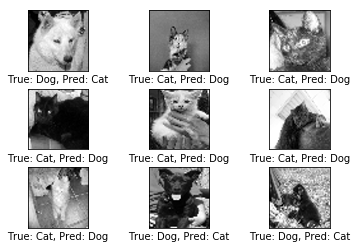

Confusion Matrix:
[[ 608 1905]
 [ 355 2132]]


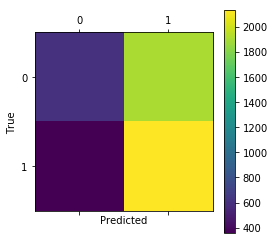

In [42]:
print_test_accuracy(show_example_errors=True, show_confusion_matrix=True)

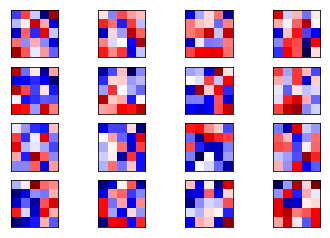

In [45]:
plot_conv_weights(weights=weights_conv1)

In [46]:
def plot_image(image):
    plt.imshow(image.reshape(img_shape),
               interpolation='nearest',
               cmap='binary')
    plt.show()

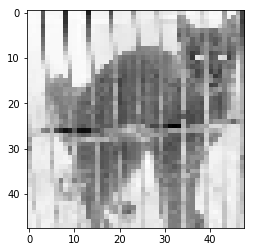

In [47]:
image1 = training_images[0]
plot_image(image1)

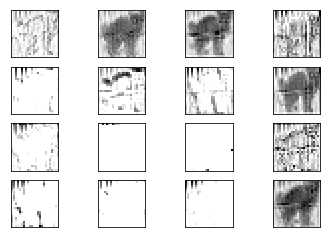

In [48]:
plot_conv_layer(layer=layer_conv1, image=image1)

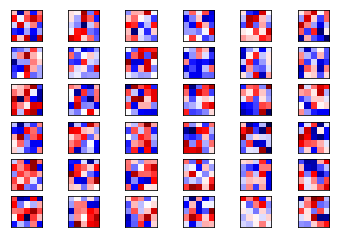

In [49]:
plot_conv_weights(weights=weights_conv2, input_channel=0)

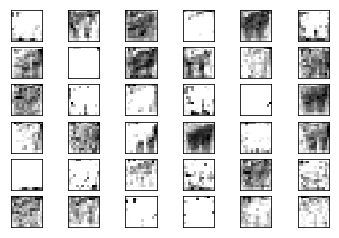

In [50]:
plot_conv_layer(layer=layer_conv2, image=image1)

In [ ]:
session.close()